# Ratio of sequencing counts to cells sorted
This Python Jupyter notebook looks at the ratio of sequencing counts to cells sorted for each sample, and flags any where this ratio seems too low.

First, import Python modules:

In [1]:
import Bio.SeqIO

from IPython.display import display, HTML

import matplotlib.pyplot as plt

import pandas as pd

from plotnine import *

import yaml

Read the configuration file:

In [2]:
with open('config.yaml') as f:
    config = yaml.safe_load(f)

Read information about the samples:

In [3]:
samples_df = pd.read_csv(config['barcode_runs'])

Read the variant counts:

In [4]:
variant_counts = pd.read_csv(config['variant_counts'])

Get the "primary target"

In [5]:
wt_seqrecord = Bio.SeqIO.read(config['wildtype_sequence'], 'fasta')
primary_target = wt_seqrecord.name
print(f"Primary target is {primary_target}")

Primary target is SARS-CoV-2


Merge the sample information and aggregated variant counts data frames into a new data frame that has the number of cells sorted and the total variant counts for each sample, as well as the ratio of the variant counts to cells.
Importantly, counts and ratios are computed using counts for all variants (SARS-CoV-2) and counts for just variants of the primary target (SARS-CoV-2).
The cell counts aren't meaningful for reference samples, so set to `NA`.

In [6]:
counts_cells = (
    samples_df
    .assign(sample_lib=lambda x: x['sample'] + ', ' + x['library'],
            cells_sorted=lambda x: x['cells_sorted'].where(x['selection'] != 'reference', pd.NA))
    [['sample_lib', 'date', 'experiment', 'antibody', 'concentration', 'selection', 'cells_sorted']]
    .merge(variant_counts
           .assign(sample_lib=lambda x: x['sample'] + ', ' + x['library'],
                   is_primary_target=lambda x: (x['target'] == primary_target).astype(int),
                   count_primary_target=lambda x: x['count'] * x['is_primary_target'])
           .groupby('sample_lib')
           .aggregate(counts_all=pd.NamedAgg('count', 'sum'),
                      counts_primary_target=pd.NamedAgg('count_primary_target', 'sum'))
           .astype(float)
           .reset_index(),
           on='sample_lib', how='left', validate='one_to_one',
           )
    .assign(sample_lib=lambda x: pd.Categorical(x['sample_lib'], reversed(x['sample_lib'].unique()), ordered=True),
            counts_all_to_cells=lambda x: x['counts_all'] / x['cells_sorted'],
            counts_primary_target_to_cells=lambda x: x['counts_primary_target'] / x['cells_sorted'],
            )
    .rename(columns={'counts_all': 'counts all variants',
                     'counts_primary_target': f"counts {primary_target} variants",
                     'counts_all_to_cells': 'counts:cells all variants',
                     'counts_primary_target_to_cells': f"counts:cells {primary_target} variants"
                     })
    )

print(f"First few lines of the data frame, writing entirety to {config['counts_to_cells_csv']}:")
display(HTML(counts_cells.head().to_html(index=False, float_format='{:.2g}'.format)))
counts_cells.to_csv(config['counts_to_cells_csv'], index=False, float_format='%.3g')

First few lines of the data frame, writing entirety to results/counts/counts_to_cells.csv:


sample_lib,date,experiment,antibody,concentration,selection,cells_sorted,counts all variants,counts SARS-CoV-2 variants,counts:cells all variants,counts:cells SARS-CoV-2 variants
"expt_24-33-none-0-reference, lib1",200904,expt_24-33,none,0,reference,<NA>,5.4e+07,5.3e+07,<NA>,<NA>
"expt_24-33-none-0-reference, lib2",200904,expt_24-33,none,0,reference,<NA>,5.8e+07,5.8e+07,<NA>,<NA>
"expt_13-16-none-0-reference, lib1",200720,expt_13-16,none,0,reference,<NA>,2.5e+07,2.5e+07,<NA>,<NA>
"expt_13-16-none-0-reference, lib2",200720,expt_13-16,none,0,reference,<NA>,2.4e+07,2.4e+07,<NA>,<NA>
"expt_7-11-none-0-reference, lib1",200616,expt_7-11,none,0,reference,<NA>,3.4e+07,3.4e+07,<NA>,<NA>


Now we plot the number of counts or the counts:cells ratio for all samples.
We stratify by reference samples and escape samples, and only plot the counts:cells ratio for escape samples as cells are not sorted for reference samples.
We plot the counts / ratios for all variants, and primary target (SARS-CoV-2) variants.

In order to have the axis limits be reasonable, we clip very high / low values and draw dotted black lines to indicate the clipping.
For reference sample counts, and escape sample counts:cells ratio, we have minimum desired values.
We draw dashed green lines at these minimum values, and keep track of samples that don't achieve the minimum.

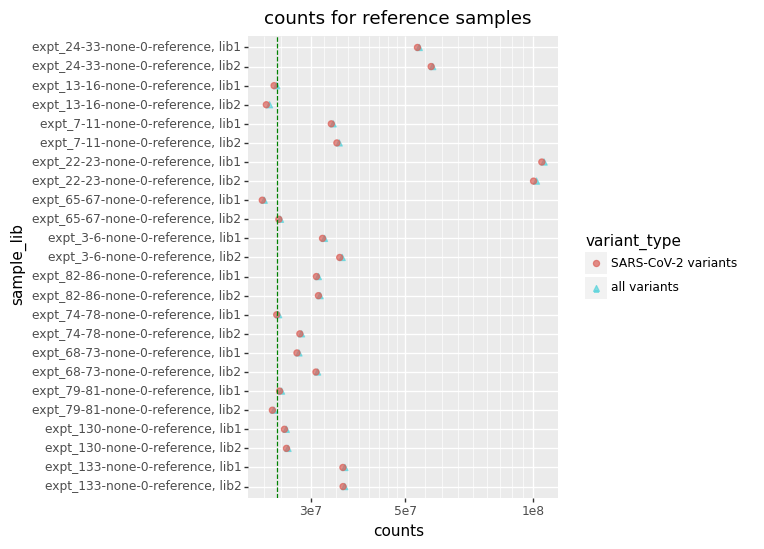

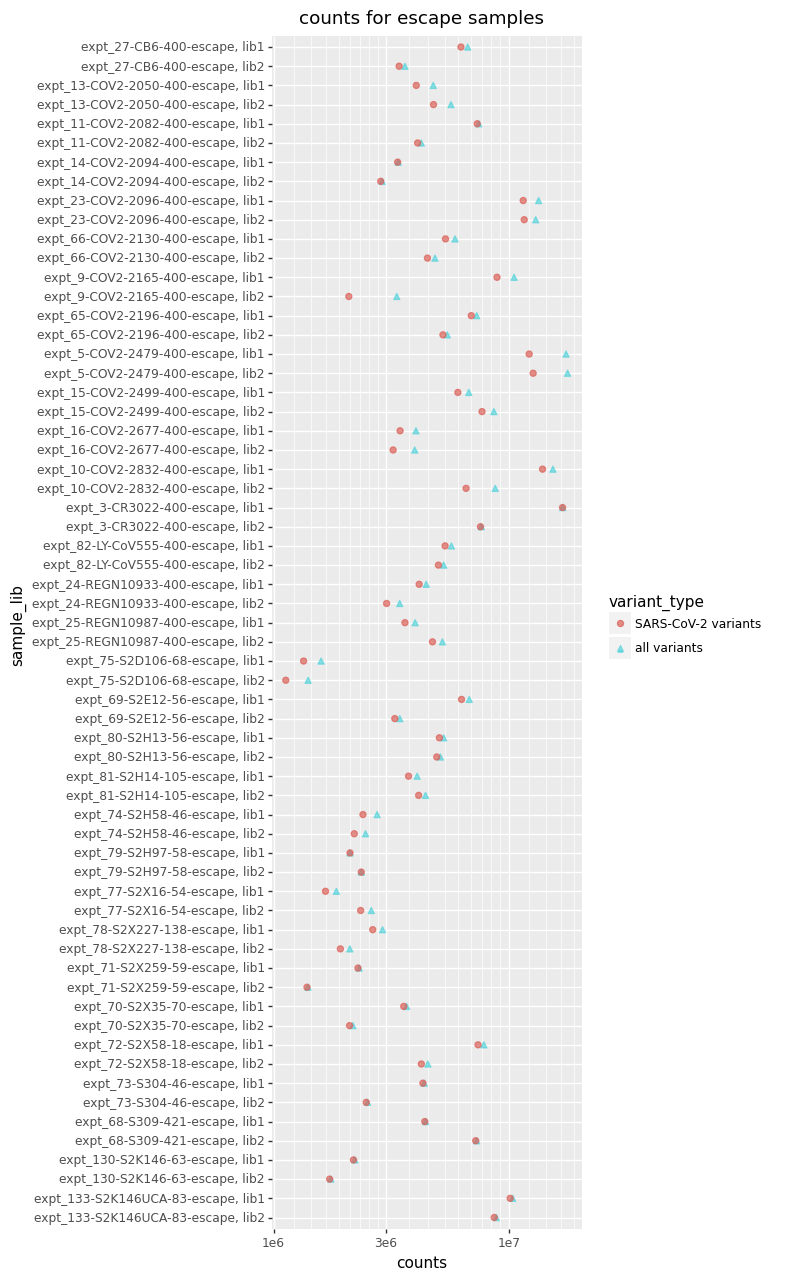

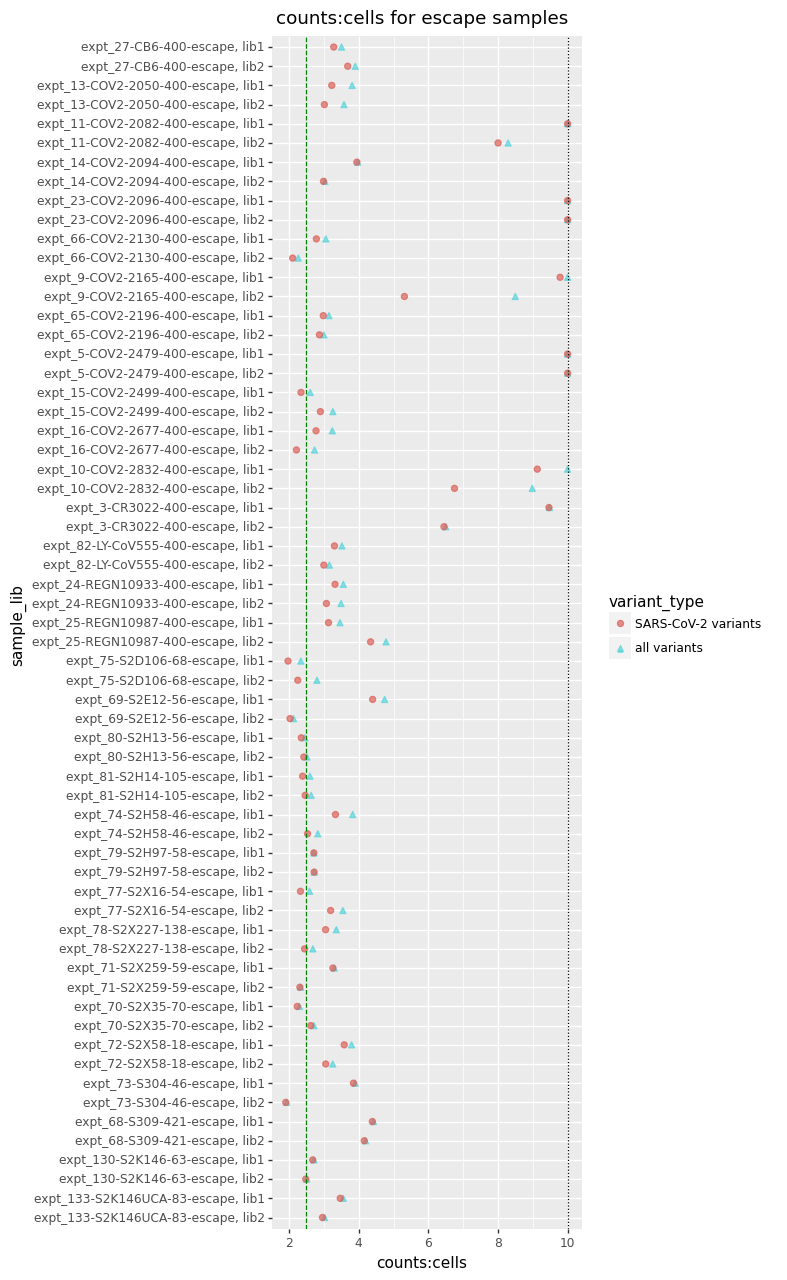

In [7]:
min_fail_sample_libs = set([])  # sample_lib that fail desired min

for var, selection, lower_clip, upper_clip, desired_min in [
            ('counts', 'reference', 1e5, None, config['reference_min_counts']),
            ('counts', 'escape', 1e5, None, None),
            ('counts:cells', 'escape', 0.1, 10, config['escape_min_counts_to_cells_ratio']),
            ]:

    # get tidy data frame with samples of interest
    tidy_df = (
        counts_cells
        .query('selection == @selection')
        .melt(id_vars='sample_lib',
              value_vars=[f"{var} all variants", f"{var} {primary_target} variants"],
              var_name='variant_type',
              value_name=var,
              )
        .assign(variant_type=lambda x: x['variant_type'].str.replace(f"{var} ", ''))
        )
    tidy_df[var] = tidy_df[var].clip(lower=lower_clip, upper=upper_clip).astype(float)

    # make plot
    p = (ggplot(tidy_df) +
         aes(var, 'sample_lib', shape='variant_type', color='variant_type') +
         geom_point(size=2, alpha=0.7) +
         theme(figure_size=(4, 0.25 * tidy_df['sample_lib'].nunique())) +
         ggtitle(f"{var} for {selection} samples")
         )
    if var == 'counts':  # plot counts on log scale
        p = p + scale_x_log10()
        
    # add dotted vertical lines if clipping if data
    if (lower_clip is not None) and (lower_clip >= tidy_df[var].min()):
        p = p + geom_vline(xintercept=lower_clip, color='black', linetype='dotted')
    if (upper_clip is not None) and (upper_clip <= tidy_df[var].max()):
        p = p + geom_vline(xintercept=upper_clip, color='black', linetype='dotted')
        
    # draw line at desired minimum value, and identify any samples that fail minimum
    if desired_min is not None:
        p = p + geom_vline(xintercept=desired_min, color='green', linetype='dashed')
        min_fail_sample_libs.update(set(
            tidy_df
            .assign(fail_min=lambda x: x[var] < desired_min)
            .query('fail_min')
            ['sample_lib']
            ))
    
    # draw figure
    fig = p.draw()
    display(fig)
    plt.close(fig)

Now list any samples that fail the minimum counts or counts:cell ratio:

In [8]:
print(f"Reference samples with < {config['reference_min_counts']} counts, "
      f"or escape samples with a counts:cell ratio < {config['escape_min_counts_to_cells_ratio']}.")

display(HTML(
    counts_cells
    .query('sample_lib in @min_fail_sample_libs')
    .to_html(index=False, float_format='{:.2g}'.format)
    ))

Reference samples with < 25000000.0 counts, or escape samples with a counts:cell ratio < 2.5.


sample_lib,date,experiment,antibody,concentration,selection,cells_sorted,counts all variants,counts SARS-CoV-2 variants,counts:cells all variants,counts:cells SARS-CoV-2 variants
"expt_13-16-none-0-reference, lib1",200720,expt_13-16,none,0,reference,<NA>,2.5e+07,2.5e+07,<NA>,<NA>
"expt_13-16-none-0-reference, lib2",200720,expt_13-16,none,0,reference,<NA>,2.4e+07,2.4e+07,<NA>,<NA>
"expt_65-67-none-0-reference, lib1",201102,expt_65-67,none,0,reference,<NA>,2.3e+07,2.3e+07,<NA>,<NA>
"expt_74-78-none-0-reference, lib1",201109,expt_74-78,none,0,reference,<NA>,2.5e+07,2.5e+07,<NA>,<NA>
"expt_79-81-none-0-reference, lib2",210113,expt_79-81,none,0,reference,<NA>,2.5e+07,2.4e+07,<NA>,<NA>
"expt_66-COV2-2130-400-escape, lib2",201102,expt_66,COV2-2130,400,escape,2.1e+06,4.9e+06,4.5e+06,2.3,2.1
"expt_15-COV2-2499-400-escape, lib1",200720,expt_15,COV2-2499,400,escape,2.6e+06,6.8e+06,6.1e+06,2.6,2.3
"expt_16-COV2-2677-400-escape, lib2",200720,expt_16,COV2-2677,400,escape,1.5e+06,4e+06,3.2e+06,2.7,2.2
"expt_75-S2D106-68-escape, lib1",201109,expt_75,S2D106,68,escape,6.8e+05,1.6e+06,1.3e+06,2.3,2
"expt_75-S2D106-68-escape, lib2",201109,expt_75,S2D106,68,escape,5e+05,1.4e+06,1.1e+06,2.8,2.3
